# 다중공선성 확인

In [2]:
import os
import numpy as np 
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler

from statistics import stdev

import xgboost as xgb 
import lightgbm as lgb
import itertools

from korean_lunar_calendar import KoreanLunarCalendar

In [3]:
BASE_DIR = './data'

In [4]:
train_path = os.path.join(BASE_DIR, '2021 빅콘테스트_데이터분석분야_퓨처스리그_홍수ZERO_댐유입량,강우,수위데이터_210902_update.xlsx')

data = pd.read_excel(train_path)
data = data[1 : ]
data = data.reset_index(drop = True)
data.iloc[:,6:] = data.iloc[:,6:].apply(pd.to_numeric)  # 수치형으로 변환

data.columns = ['홍수사상번호', '연', '월', '일', '시간', '유입량', 
                '1_유역평균강수', '1_강우(A지역)', '1_강우(B지역)', '1_강우(C지역)', '1_강우(D지역)', '1_수위(E지역)', '1_수위(D지역)', 
                '2_유역평균강수', '2_강우(A지역)', '2_강우(B지역)', '2_강우(C지역)', '2_강우(D지역)', '2_수위(E지역)', '2_수위(D지역)', 
                '3_유역평균강수', '3_강우(A지역)', '3_강우(B지역)', '3_강우(C지역)', '3_강우(D지역)', '3_수위(E지역)', '3_수위(D지역)',
                '4_유역평균강수', '4_강우(A지역)', '4_강우(B지역)', '4_강우(C지역)', '4_강우(D지역)', '4_수위(E지역)', '4_수위(D지역)',
                '5_유역평균강수', '5_강우(A지역)', '5_강우(B지역)', '5_강우(C지역)', '5_강우(D지역)', '5_수위(E지역)', '5_수위(D지역)',
                '6_유역평균강수', '6_강우(A지역)', '6_강우(B지역)', '6_강우(C지역)', '6_강우(D지역)', '6_수위(E지역)', '6_수위(D지역)']

여기서 모델링을 한번

In [ ]:
# 데이터 스케일링 (object는 category형으로, 수치형은 스케일링)
def scale_data(data, target, scale = 'minmax', transform_feature = []) :
    tg = data[[target]]
    data.drop([target], axis = 1, inplace = True)

    cat_columns = [c for c, t in zip(data.dtypes.index, data.dtypes) if t=='O'] 
    num_columns = [c for c in data.columns if c not in cat_columns]

    if len(transform_feature) > 0 :
        for i in transform_feature :
            data[i] = np.log1p(data[i])
  
    if scale == 'zscore' :
        scaler = StandardScaler()
        num_data = data[num_columns].values
        scaler.fit(num_data)
        scaled_data = scaler.transform(num_data)
        scaled_data = pd.DataFrame(data=scaled_data, columns=num_columns)

    else :
    scaler = MinMaxScaler()
    num_data = data[num_columns].values
    scaler.fit(num_data)
    scaled_data = scaler.transform(num_data)
    scaled_data = pd.DataFrame(data=scaled_data, columns=num_columns)

    for i in cat_columns :
        data[i] = data[i].astype('category')

    data = data.reset_index(drop = True)
    data = pd.concat([data[cat_columns], scaled_data], axis = 1)
    data = pd.concat([data, tg], axis = 1)
    return data

In [ ]:
data['홍수사상번호'] = data['홍수사상번호'].astype('object')
data['시간'] = data['시간'].astype('object')
scaled_data_lgb = data.copy()
scaled_data_lgb = scale_data(scaled_data_lgb, '유입량')

In [ ]:
test_set = scaled_data_lgb[scaled_data_lgb['홍수사상번호'].isin([25])]
train_set = scaled_data_lgb[~scaled_data_lgb['홍수사상번호'].isin([1, 25, 26])]
test_set_y = test_set[['유입량']]
train_set_y = train_set[['유입량']]

test_set.drop(['유입량', '일시', '연', '월', '일'], axis = 1, inplace = True)
train_set.drop(['유입량', '일시', '연', '월', '일'], axis = 1, inplace = True)

In [ ]:
train_set

,홍수사상번호,시간,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),2_강우(B지역),2_강우(C지역),2_강우(D지역),2_수위(E지역),2_수위(D지역),3_유역평균강수,3_강우(A지역),3_강우(B지역),3_강우(C지역),3_강우(D지역),3_수위(E지역),3_수위(D지역),4_유역평균강수,4_강우(A지역),4_강우(B지역),4_강우(C지역),4_강우(D지역),4_수위(E지역),4_수위(D지역),5_유역평균강수,5_강우(A지역),5_강우(B지역),5_강우(C지역),5_강우(D지역),5_수위(E지역),5_수위(D지역),6_유역평균강수,6_강우(A지역),6_강우(B지역),6_강우(C지역),6_강우(D지역),6_수위(E지역),6_수위(D지역),기온,풍속,습도
226,2.0,24.0,0.000000,0.000000,0.002725,0.000000,0.000000,0.118850,0.624907,0.000000,0.000000,0.002725,0.000000,0.000000,0.118850,0.621702,0.000000,0.000000,0.002801,0.000000,0.000000,0.118850,0.621042,0.001469,0.000000,0.002801,0.003623,0.000000,0.118850,0.629351,0.001479,0.000000,0.002801,0.003623,0.000000,0.118850,0.628081,0.001515,0.000000,0.002786,0.004049,0.000000,0.118850,0.626614,0.546256,0.019608,0.818182
227,2.0,1.0,0.000000,0.000000,0.005450,0.000000,0.000000,0.117572,0.624163,0.001523,0.000000,0.005450,0.000000,0.000000,0.117572,0.621042,0.001523,0.000000,0.005602,0.000000,0.000000,0.117572,0.620053,0.004514,0.002899,0.005602,0.007246,0.003817,0.117572,0.628640,0.004544,0.002899,0.005602,0.007246,0.003817,0.117572,0.627286,0.004656,0.002899,0.005571,0.008097,0.003831,0.117572,0.626018,0.519824,0.117647,0.848485
228,2.0,2.0,0.001523,0.000000,0.005450,0.000000,0.000000,0.116933,0.623170,0.004568,0.002967,0.005450,0.000000,0.000000,0.116933,0.620053,0.004568,0.002967,0.005602,0.003984,0.000000,0.116933,0.619063,0.007864,0.005797,0.005602,0.010870,0.007634,0.116933,0.627930,0.007917,0.005797,0.005602,0.010870,0.007634,0.116933,0.626491,0.008111,0.005797,0.005571,0.012146,0.007663,0.116933,0.625223,0.524229,0.058824,0.848485
229,2.0,3.0,0.004568,0.000000,0.008174,0.000000,0.000000,0.116294,0.622426,0.007917,0.005935,0.008174,0.003984,0.000000,0.116294,0.619063,0.007917,0.005935,0.008403,0.007968,0.003817,0.116294,0.618074,0.012127,0.017391,0.008403,0.014493,0.011450,0.116294,0.627220,0.012209,0.017391,0.008403,0.014493,0.011450,0.116294,0.625696,0.012508,0.017391,0.008357,0.016194,0.011494,0.116294,0.624429,0.506608,0.000000,0.863636
230,2.0,4.0,0.007917,0.003040,0.010899,0.003953,0.003817,0.115655,0.621682,0.012180,0.017804,0.010899,0.007968,0.003817,0.115655,0.618074,0.012180,0.017804,0.011204,0.011952,0.007634,0.115655,0.617084,0.016390,0.031884,0.011204,0.014493,0.015267,0.115655,0.626509,0.016501,0.031884,0.011204,0.014493,0.015267,0.115655,0.625060,0.016905,0.031884,0.011142,0.016194,0.015326,0.115655,0.623635,0.502203,0.137255,0.878788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2783,24.0,6.0,0.508166,0.705167,0.384196,0.237154,0.332061,0.249840,0.170677,0.484226,0.688427,0.370572,0.239044,0.332061,0.249840,0.188325,0.484226,0.688427,0.350140,0.239044,0.297710,0.249840,0.195251,0.466277,0.672464,0.350140,0.510870,0.278626,0.249840,0.129848,0.426650,0.672464,0.350140,0.510870,0.278626,0.249840,0.140722,0.367402,0.672464,0.356546,0.242915,0.279693,0.249840,0.153128,0.568282,0.333333,0.969697
2784,24.0,7.0,0.484226,0.699088,0.370572,0.237154,0.297710,0.242812,0.178616,0.466305,0.682493,0.365123,0.239044,0.297710,0.242812,0.195251,0.466305,0.682493,0.350140,0.239044,0.278626,0.242812,0.201517,0.441885,0.666667,0.350140,0.507246,0.278626,0.242812,0.136951,0.404367,0.666667,0.350140,0.507246,0.278626,0.242812,0.148036,0.339140,0.666667,0.348189,0.242915,0.279693,0.242812,0.160874,0.581498,0.176471,0.863636
2785,24.0,8.0,0.466305,0.696049,0.365123,0.237154,0.278626,0.235783,0.186058,0.441915,0.679525,0.365123,0.239044,0.278626,0.235783,0.201517,0.441915,0.679525,0.347339,0.239044,0.278626,0.235783,0.207784,0.423791,0.663768,0.347339,0.369565,0.278626,0.235783,0.144055,0.390602,0.663768,0.347339,0.369565,0.278626,0.235783,0.155351,0.321566,0.663768,0.348189,0.242915,0.279693,0.235783,0.168421,0.634361,0.176471,0.757576
2786,24.0,9.0,0.441915,0.650456

## 기온

In [ ]:
weather_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/빅콘테스트_홍수/기상청데이터/기상데이터.csv', encoding = 'euc-kr')
print('기상데이터 적용 전 :', data.shape)
data = pd.merge(data, weather_data,left_index=True, right_index=True, how='left')

print('기상데이터 적용 후 :', data.shape)

기상데이터 적용 전 : (3051, 48)
기상데이터 적용 후 : (3051, 52)


## 음력

In [ ]:
solar_date = data[['연', '월', '일']]

# 음력 변환
calendar = KoreanLunarCalendar()

output = []
for i in range(len(solar_date)) :
  year = int(solar_date['연'][i])
  month = int(solar_date['월'][i])
  day = int(solar_date['일'][i])
  calendar.setSolarDate(year, month, day)
  result = calendar.LunarIsoFormat()
  output.append(result)

month = []
day = []
for i in range(len(output)) :
  month.append(output[i].split('-')[1])
  day.append(output[i].split('-')[2].split(' ')[0])

lunar_date = pd.DataFrame([output, month, day]).T
lunar_date.columns = ['음력', '음력_월', '음력_일']

lunar_date['음력_월'] = lunar_date['음력_월'].astype('int')
lunar_date['음력_일'] = lunar_date['음력_일'].astype('int')

In [ ]:
data_feat = pd.concat([data, lunar_date], axis = 1)

In [ ]:
col = ['유입량', '1_유역평균강수', '1_강우(A지역)',
       '1_강우(B지역)', '1_강우(C지역)', '1_강우(D지역)', '1_수위(E지역)', '1_수위(D지역)',
       '2_유역평균강수', '2_강우(A지역)', '2_강우(B지역)', '2_강우(C지역)', '2_강우(D지역)',
       '2_수위(E지역)', '2_수위(D지역)', '3_유역평균강수', '3_강우(A지역)', '3_강우(B지역)',
       '3_강우(C지역)', '3_강우(D지역)', '3_수위(E지역)', '3_수위(D지역)', '4_유역평균강수',
       '4_강우(A지역)', '4_강우(B지역)', '4_강우(C지역)', '4_강우(D지역)', '4_수위(E지역)',
       '4_수위(D지역)', '5_유역평균강수', '5_강우(A지역)', '5_강우(B지역)', '5_강우(C지역)',
       '5_강우(D지역)', '5_수위(E지역)', '5_수위(D지역)', '6_유역평균강수', '6_강우(A지역)',
       '6_강우(B지역)', '6_강우(C지역)', '6_강우(D지역)', '6_수위(E지역)', '6_수위(D지역)']

## 새로운 집단 7 만들어보기

- https://colab.research.google.com/drive/1bsFjsCi-hCGy6uux5ItNhmFZhRfCMQ3b?usp=sharing
- 집단 1 ~ 6까지의 변수들을 각각 최소값과 최대값을 뺀 나머지 4개의 값의 평균으로 집단 7을 만들어보았음

- 수위(E지역)은 모든 집단이 같으므로 안만들었음

In [ ]:
data_7 = data_feat[['1_유역평균강수', '2_유역평균강수', '3_유역평균강수', '4_유역평균강수', '5_유역평균강수', '6_유역평균강수']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
  lst.append(list(data_7.loc[i]))
  lst[i].sort()
  lst[i].pop()
  lst[i].sort(reverse = True)
  lst[i].pop()
  lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.DataFrame(lst_mean, columns = ['7_유역평균강수'])

data_7 = data_feat[['1_강우(A지역)', '2_강우(A지역)', '3_강우(A지역)', '4_강우(A지역)', '5_강우(A지역)', '6_강우(A지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
  lst.append(list(data_7.loc[i]))
  lst[i].sort()
  lst[i].pop()
  lst[i].sort(reverse = True)
  lst[i].pop()
  lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(A지역)'])], axis = 1)

data_7 = data_feat[['1_강우(B지역)', '2_강우(B지역)', '3_강우(B지역)', '4_강우(B지역)', '5_강우(B지역)', '6_강우(B지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
  lst.append(list(data_7.loc[i]))
  lst[i].sort()
  lst[i].pop()
  lst[i].sort(reverse = True)
  lst[i].pop()
  lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(B지역)'])], axis = 1)

data_7 = data_feat[['1_강우(C지역)', '2_강우(C지역)', '3_강우(C지역)', '4_강우(C지역)', '5_강우(C지역)', '6_강우(C지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
  lst.append(list(data_7.loc[i]))
  lst[i].sort()
  lst[i].pop()
  lst[i].sort(reverse = True)
  lst[i].pop()
  lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(C지역)'])], axis = 1)

data_7 = data_feat[['1_강우(D지역)', '2_강우(D지역)', '3_강우(D지역)', '4_강우(D지역)', '5_강우(D지역)', '6_강우(D지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
  lst.append(list(data_7.loc[i]))
  lst[i].sort()
  lst[i].pop()
  lst[i].sort(reverse = True)
  lst[i].pop()
  lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_강우(D지역)'])], axis = 1)

data_7 = data_feat[['1_수위(D지역)', '2_수위(D지역)', '3_수위(D지역)', '4_수위(D지역)', '5_수위(D지역)', '6_수위(D지역)']]
lst = []
lst_mean = []
for i in range(len(data_7)) :
  lst.append(list(data_7.loc[i]))
  lst[i].sort()
  lst[i].pop()
  lst[i].sort(reverse = True)
  lst[i].pop()
  lst_mean.append(np.mean(lst[i]))

data_feat_7 = pd.concat([data_feat_7, pd.DataFrame(lst_mean, columns = ['7_수위(D지역)'])], axis = 1)
data_feat = pd.concat([data_feat, data_feat_7], axis = 1)

## rolling

In [ ]:
# rolling 1

data_rolling = data_feat[['홍수사상번호']]
lst = [data_rolling[data_rolling['홍수사상번호'] == i].iloc[0 : 1].index for i in range(1, 27)]
lst = list(itertools.chain.from_iterable(lst))

data_rolling['7_유역평균강수_shift_1'] = data_feat['7_유역평균강수'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_1'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_유역평균강수_shift_1'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_유역평균강수_shift_1'] = dx

data_rolling['7_강우(A지역)_shift_1'] = data_feat['7_강우(A지역)'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_1'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_1'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_1'] = dx

data_rolling['7_강우(B지역)_shift_1'] = data_feat['7_강우(B지역)'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_1'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_1'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_1'] = dx

data_rolling['7_강우(C지역)_shift_1'] = data_feat['7_강우(C지역)'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_1'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_1'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_1'] = dx

data_rolling['7_강우(D지역)_shift_1'] = data_feat['7_강우(D지역)'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_1'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_1'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_1'] = dx

data_rolling['7_수위(D지역)_shift_1'] = data_feat['7_수위(D지역)'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_1'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_1'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_1'] = dx

data_rolling['1_수위(E지역)_shift_1'] = data_feat['1_수위(E지역)'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['1_수위(E지역)_shift_1'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['1_수위(E지역)_shift_1'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['1_수위(E지역)_shift_1'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '1_수위(E지역)_shift_1'] = 0
  else :
    data_rolling.loc[lst[i-1], '1_수위(E지역)_shift_1'] = dx

data_rolling = data_rolling.drop(['홍수사상번호'], axis = 1)

data_feat = pd.concat([data_feat, data_rolling], axis = 1)

In [ ]:
# rolling 2

data_rolling = data_feat[['홍수사상번호']]
lst = [data_rolling[data_rolling['홍수사상번호'] == i].iloc[0 : 1].index for i in range(1, 27)]
lst = list(itertools.chain.from_iterable(lst))

data_rolling['7_유역평균강수_shift_2'] = data_feat['7_유역평균강수_shift_1'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_2'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_유역평균강수_shift_2'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_유역평균강수_shift_2'] = dx

data_rolling['7_강우(A지역)_shift_2'] = data_feat['7_강우(A지역)_shift_1'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_2'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_2'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_2'] = dx

data_rolling['7_강우(B지역)_shift_2'] = data_feat['7_강우(B지역)_shift_1'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_2'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_2'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_2'] = dx

data_rolling['7_강우(C지역)_shift_2'] = data_feat['7_강우(C지역)_shift_1'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_2'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_2'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_2'] = dx

data_rolling['7_강우(D지역)_shift_2'] = data_feat['7_강우(D지역)_shift_1'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_2'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_2'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_2'] = dx

data_rolling['7_수위(D지역)_shift_2'] = data_feat['7_수위(D지역)_shift_1'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_2'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_2'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_2'] = dx

data_rolling['1_수위(E지역)_shift_2'] = data_feat['1_수위(E지역)_shift_1'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['1_수위(E지역)_shift_2'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['1_수위(E지역)_shift_2'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['1_수위(E지역)_shift_2'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '1_수위(E지역)_shift_2'] = 0
  else :
    data_rolling.loc[lst[i-1], '1_수위(E지역)_shift_2'] = dx

data_rolling = data_rolling.drop(['홍수사상번호'], axis = 1)

data_feat = pd.concat([data_feat, data_rolling], axis = 1)

In [ ]:
# rolling 3

data_rolling = data_feat[['홍수사상번호']]
lst = [data_rolling[data_rolling['홍수사상번호'] == i].iloc[0 : 1].index for i in range(1, 27)]
lst = list(itertools.chain.from_iterable(lst))

data_rolling['7_유역평균강수_shift_3'] = data_feat['7_유역평균강수_shift_2'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_유역평균강수_shift_3'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_유역평균강수_shift_3'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_유역평균강수_shift_3'] = dx

data_rolling['7_강우(A지역)_shift_3'] = data_feat['7_강우(A지역)_shift_2'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(A지역)_shift_3'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_3'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(A지역)_shift_3'] = dx

data_rolling['7_강우(B지역)_shift_3'] = data_feat['7_강우(B지역)_shift_2'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(B지역)_shift_3'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_3'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(B지역)_shift_3'] = dx

data_rolling['7_강우(C지역)_shift_3'] = data_feat['7_강우(C지역)_shift_2'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(C지역)_shift_3'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_3'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(C지역)_shift_3'] = dx

data_rolling['7_강우(D지역)_shift_3'] = data_feat['7_강우(D지역)_shift_2'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_강우(D지역)_shift_3'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_3'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_강우(D지역)_shift_3'] = dx

data_rolling['7_수위(D지역)_shift_3'] = data_feat['7_수위(D지역)_shift_2'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['7_수위(D지역)_shift_3'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_3'] = 0
  else :
    data_rolling.loc[lst[i-1], '7_수위(D지역)_shift_3'] = dx

data_rolling['1_수위(E지역)_shift_3'] = data_feat['1_수위(E지역)_shift_2'].shift(1)
for i in range(1, 27) :
  dx = data_rolling[data_rolling['홍수사상번호'] == i]['1_수위(E지역)_shift_3'].iloc[1] - (data_rolling[data_rolling['홍수사상번호'] == i]['1_수위(E지역)_shift_3'].iloc[2] - data_rolling[data_rolling['홍수사상번호'] == i]['1_수위(E지역)_shift_3'].iloc[1])
  if dx < 0 :
    data_rolling.loc[lst[i-1], '1_수위(E지역)_shift_3'] = 0
  else :
    data_rolling.loc[lst[i-1], '1_수위(E지역)_shift_3'] = dx

data_rolling = data_rolling.drop(['홍수사상번호'], axis = 1)

data_feat = pd.concat([data_feat, data_rolling], axis = 1)

## diff

In [ ]:
data_feat['7_유역평균강수_diff'] = pd.DataFrame(data_feat['7_유역평균강수'] - data_feat['7_유역평균강수_shift_1'])
data_feat['7_강우(A지역)_diff'] = pd.DataFrame(data_feat['7_강우(A지역)'] - data_feat['7_강우(A지역)_shift_1'])
data_feat['7_강우(B지역)_diff'] = pd.DataFrame(data_feat['7_강우(B지역)'] - data_feat['7_강우(B지역)_shift_1'])
data_feat['7_강우(C지역)_diff'] = pd.DataFrame(data_feat['7_강우(C지역)'] - data_feat['7_강우(C지역)_shift_1'])
data_feat['7_강우(D지역)_diff'] = pd.DataFrame(data_feat['7_강우(D지역)'] - data_feat['7_강우(D지역)_shift_1'])
data_feat['7_수위(D지역)_diff'] = pd.DataFrame(data_feat['7_수위(D지역)'] - data_feat['7_수위(D지역)_shift_1'])
data_feat['1_수위(E지역)_diff'] = pd.DataFrame(data_feat['1_수위(E지역)'] - data_feat['1_수위(E지역)_shift_1'])

In [ ]:
data_feat

,홍수사상번호,연,월,일,시간,유입량,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),2_강우(B지역),2_강우(C지역),2_강우(D지역),2_수위(E지역),2_수위(D지역),3_유역평균강수,3_강우(A지역),3_강우(B지역),3_강우(C지역),3_강우(D지역),3_수위(E지역),3_수위(D지역),4_유역평균강수,4_강우(A지역),4_강우(B지역),4_강우(C지역),4_강우(D지역),4_수위(E지역),4_수위(D지역),5_유역평균강수,5_강우(A지역),5_강우(B지역),5_강우(C지역),5_강우(D지역),5_수위(E지역),...,기온,풍속,습도,음력,음력_월,음력_일,7_유역평균강수,7_강우(A지역),7_강우(B지역),7_강우(C지역),7_강우(D지역),7_수위(D지역),7_유역평균강수_shift_1,7_강우(A지역)_shift_1,7_강우(B지역)_shift_1,7_강우(C지역)_shift_1,7_강우(D지역)_shift_1,7_수위(D지역)_shift_1,1_수위(E지역)_shift_1,7_유역평균강수_shift_2,7_강우(A지역)_shift_2,7_강우(B지역)_shift_2,7_강우(C지역)_shift_2,7_강우(D지역)_shift_2,7_수위(D지역)_shift_2,1_수위(E지역)_shift_2,7_유역평균강수_shift_3,7_강우(A지역)_shift_3,7_강우(B지역)_shift_3,7_강우(C지역)_shift_3,7_강우(D지역)_shift_3,7_수위(D지역)_shift_3,1_수위(E지역)_shift_3,7_유역평균강수_diff,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,1_수위(E지역)_diff
0,1.0,2006.0,7.0,10.0,8.0,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,...,24.3,2.0,85.0,2006-06-15,6,15,6.375000,7.0,7.0,7.50,8.00,122.597188,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,5.42500,7.0,5.0,5.50,6.0,122.607146,2.56,4.950000,7.0,4.0,4.50,5.0,122.612125,2.57,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01
1,1.0,2006.0,7.0,10.0,9.0,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,...,24.6,1.5,83.0,2006-06-15,6,15,6.850000,7.0,8.0,8.50,9.00,122.592208,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,5.90000,7.0,6.0,6.50,7.0,122.602167,2.55,5.425000,7.0,5.0,5.50,6.0,122.607146,2.56,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01
2,1.0,2006.0,7.0,10.0,10.0,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,...,25.4,1.6,79.0,2006-06-15,6,15,7.750000,7.0,9.0,8.75,9.50,122.587750,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,6.37500,7.0,7.0,7.50,8.0,122.597188,2.54,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,0.900000,0.0,1.0,0.25,0.50,-0.004458,0.00
3,1.0,2006.0,7.0,10.0,11.0,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,...,25.4,0.9,82.0,2006-06-15,6,15,9.750000,8.0,10.0,12.00,11.50,122.586667,7.750000,7.0,9.0,8.75,9.5,122.587750,2.53,6.85000,7.0,8.0,8.50,9.0,122.592208,2.53,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,2.000000,1.0,1.0,3.25,2.00,-0.001083,0.00
4,1.0,2006.0,7.0,10.0,12.0,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,...,25.3,0.8,81.0,2006-06-15,6,15,12.850000,10.5,12.0,14.00,13.25,122.582250,9.750000,8.0,10.0,12.00,11.5,122.586667,2.53,7.75000,7.0,9.0,8.75,9.5,122.587750,2.53,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,3.100000,2.5,2.0,2.00,1.75,-0.004417,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26.0,2018.0,7.0,7.0,17.0,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,...,23.5,3.6,56.0,2018-05-24,5,24,2.368900,1.0,0.0,0.25,0.00,129.969104,2.368900,1.0,0.0,0.50,0.0,129.957229,3.18,2.39935,1.0,0.0,0.50,0.0,129.939375,3.19,2.611575,1.0,0.0,0.75,0.0,129.925417,3.21,0.000000,0.0,0.0,-0.25,0.00,0.011875,-0.02
3047,26.0,2018.0,7.0,7.0,18.0,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,...,23

## 홍수기간 칼럼 생성

In [ ]:
rain = data_feat.groupby('홍수사상번호')['시간'].count()
lst = np.array(rain.tolist())

flood = []
for i in range(26):
  x = list(range(1, lst[i]+1))
  flood.extend(x)

flood = pd.DataFrame(flood)
flood.columns = ['홍수기간']
data_feat = pd.concat([data_feat, flood], axis = 1)

data_feat

,홍수사상번호,연,월,일,시간,유입량,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),2_강우(B지역),2_강우(C지역),2_강우(D지역),2_수위(E지역),2_수위(D지역),3_유역평균강수,3_강우(A지역),3_강우(B지역),3_강우(C지역),3_강우(D지역),3_수위(E지역),3_수위(D지역),4_유역평균강수,4_강우(A지역),4_강우(B지역),4_강우(C지역),4_강우(D지역),4_수위(E지역),4_수위(D지역),5_유역평균강수,5_강우(A지역),5_강우(B지역),5_강우(C지역),5_강우(D지역),5_수위(E지역),...,풍속,습도,음력,음력_월,음력_일,7_유역평균강수,7_강우(A지역),7_강우(B지역),7_강우(C지역),7_강우(D지역),7_수위(D지역),7_유역평균강수_shift_1,7_강우(A지역)_shift_1,7_강우(B지역)_shift_1,7_강우(C지역)_shift_1,7_강우(D지역)_shift_1,7_수위(D지역)_shift_1,1_수위(E지역)_shift_1,7_유역평균강수_shift_2,7_강우(A지역)_shift_2,7_강우(B지역)_shift_2,7_강우(C지역)_shift_2,7_강우(D지역)_shift_2,7_수위(D지역)_shift_2,1_수위(E지역)_shift_2,7_유역평균강수_shift_3,7_강우(A지역)_shift_3,7_강우(B지역)_shift_3,7_강우(C지역)_shift_3,7_강우(D지역)_shift_3,7_수위(D지역)_shift_3,1_수위(E지역)_shift_3,7_유역평균강수_diff,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,1_수위(E지역)_diff,홍수기간
0,1.0,2006.0,7.0,10.0,8.0,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,...,2.0,85.0,2006-06-15,6,15,6.375000,7.0,7.0,7.50,8.00,122.597188,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,5.42500,7.0,5.0,5.50,6.0,122.607146,2.56,4.950000,7.0,4.0,4.50,5.0,122.612125,2.57,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,1
1,1.0,2006.0,7.0,10.0,9.0,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,...,1.5,83.0,2006-06-15,6,15,6.850000,7.0,8.0,8.50,9.00,122.592208,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,5.90000,7.0,6.0,6.50,7.0,122.602167,2.55,5.425000,7.0,5.0,5.50,6.0,122.607146,2.56,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,2
2,1.0,2006.0,7.0,10.0,10.0,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,...,1.6,79.0,2006-06-15,6,15,7.750000,7.0,9.0,8.75,9.50,122.587750,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,6.37500,7.0,7.0,7.50,8.0,122.597188,2.54,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,0.900000,0.0,1.0,0.25,0.50,-0.004458,0.00,3
3,1.0,2006.0,7.0,10.0,11.0,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,...,0.9,82.0,2006-06-15,6,15,9.750000,8.0,10.0,12.00,11.50,122.586667,7.750000,7.0,9.0,8.75,9.5,122.587750,2.53,6.85000,7.0,8.0,8.50,9.0,122.592208,2.53,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,2.000000,1.0,1.0,3.25,2.00,-0.001083,0.00,4
4,1.0,2006.0,7.0,10.0,12.0,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,...,0.8,81.0,2006-06-15,6,15,12.850000,10.5,12.0,14.00,13.25,122.582250,9.750000,8.0,10.0,12.00,11.5,122.586667,2.53,7.75000,7.0,9.0,8.75,9.5,122.587750,2.53,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,3.100000,2.5,2.0,2.00,1.75,-0.004417,0.00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26.0,2018.0,7.0,7.0,17.0,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,...,3.6,56.0,2018-05-24,5,24,2.368900,1.0,0.0,0.25,0.00,129.969104,2.368900,1.0,0.0,0.50,0.0,129.957229,3.18,2.39935,1.0,0.0,0.50,0.0,129.939375,3.19,2.611575,1.0,0.0,0.75,0.0,129.925417,3.21,0.000000,0.0,0.0,-0.25,0.00,0.011875,-0.02,156
3047,26.0,2018.0,7.0,7.0,18.0,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,...,3.4,56.0,2018-05

## 홍수기간 Binning
- 장마기간의 최댓값 285 & 최솟값 34 사이의 구간을 지정해야 함

### [0,30, 50, 70, 100, 120, 160, 220, 260, 280] 으로 나누기 (편한대로 바꿔도 됨)

In [ ]:
bins = [0,30, 50, 70, 100, 120, 160, 220, 260, 280] 
data_feat['홍수_bin'] = np.digitize(data_feat['홍수기간'], bins)
data_feat.groupby('홍수_bin')[['홍수기간']].count()

,홍수기간
홍수_bin,
1,754
2,494
3,416
4,480
5,196
6,263
7,287
8,127
9,28


In [ ]:
data_feat

,홍수사상번호,연,월,일,시간,유입량,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),2_강우(B지역),2_강우(C지역),2_강우(D지역),2_수위(E지역),2_수위(D지역),3_유역평균강수,3_강우(A지역),3_강우(B지역),3_강우(C지역),3_강우(D지역),3_수위(E지역),3_수위(D지역),4_유역평균강수,4_강우(A지역),4_강우(B지역),4_강우(C지역),4_강우(D지역),4_수위(E지역),4_수위(D지역),5_유역평균강수,5_강우(A지역),5_강우(B지역),5_강우(C지역),5_강우(D지역),5_수위(E지역),...,습도,음력,음력_월,음력_일,7_유역평균강수,7_강우(A지역),7_강우(B지역),7_강우(C지역),7_강우(D지역),7_수위(D지역),7_유역평균강수_shift_1,7_강우(A지역)_shift_1,7_강우(B지역)_shift_1,7_강우(C지역)_shift_1,7_강우(D지역)_shift_1,7_수위(D지역)_shift_1,1_수위(E지역)_shift_1,7_유역평균강수_shift_2,7_강우(A지역)_shift_2,7_강우(B지역)_shift_2,7_강우(C지역)_shift_2,7_강우(D지역)_shift_2,7_수위(D지역)_shift_2,1_수위(E지역)_shift_2,7_유역평균강수_shift_3,7_강우(A지역)_shift_3,7_강우(B지역)_shift_3,7_강우(C지역)_shift_3,7_강우(D지역)_shift_3,7_수위(D지역)_shift_3,1_수위(E지역)_shift_3,7_유역평균강수_diff,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,1_수위(E지역)_diff,홍수기간,홍수_bin
0,1.0,2006.0,7.0,10.0,8.0,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,...,85.0,2006-06-15,6,15,6.375000,7.0,7.0,7.50,8.00,122.597188,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,5.42500,7.0,5.0,5.50,6.0,122.607146,2.56,4.950000,7.0,4.0,4.50,5.0,122.612125,2.57,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,1,1
1,1.0,2006.0,7.0,10.0,9.0,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,...,83.0,2006-06-15,6,15,6.850000,7.0,8.0,8.50,9.00,122.592208,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,5.90000,7.0,6.0,6.50,7.0,122.602167,2.55,5.425000,7.0,5.0,5.50,6.0,122.607146,2.56,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,2,1
2,1.0,2006.0,7.0,10.0,10.0,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,...,79.0,2006-06-15,6,15,7.750000,7.0,9.0,8.75,9.50,122.587750,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,6.37500,7.0,7.0,7.50,8.0,122.597188,2.54,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,0.900000,0.0,1.0,0.25,0.50,-0.004458,0.00,3,1
3,1.0,2006.0,7.0,10.0,11.0,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,...,82.0,2006-06-15,6,15,9.750000,8.0,10.0,12.00,11.50,122.586667,7.750000,7.0,9.0,8.75,9.5,122.587750,2.53,6.85000,7.0,8.0,8.50,9.0,122.592208,2.53,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,2.000000,1.0,1.0,3.25,2.00,-0.001083,0.00,4,1
4,1.0,2006.0,7.0,10.0,12.0,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,...,81.0,2006-06-15,6,15,12.850000,10.5,12.0,14.00,13.25,122.582250,9.750000,8.0,10.0,12.00,11.5,122.586667,2.53,7.75000,7.0,9.0,8.75,9.5,122.587750,2.53,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,3.100000,2.5,2.0,2.00,1.75,-0.004417,0.00,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26.0,2018.0,7.0,7.0,17.0,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,...,56.0,2018-05-24,5,24,2.368900,1.0,0.0,0.25,0.00,129.969104,2.368900,1.0,0.0,0.50,0.0,129.957229,3.18,2.39935,1.0,0.0,0.50,0.0,129.939375,3.19,2.611575,1.0,0.0,0.75,0.0,129.925417,3.21,0.000000,0.0,0.0,-0.25,0.00,0.011875,-0.02,156,6
3047,26.0,2018.0,7.0,7.0,18.0,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,...,56.0,2018-05-24,5,24,2.3

## KMEANS

In [ ]:
# kmeans를 하기위해서는 변수들이 수치형데이터여야 한다. 그리고 타겟변수인 유입량도 빼준다.
# 그리고 시간의 영향을 제거해보기 위해 시간관련 열들도 제거해본다
data_feat_target = data_feat[data_feat['홍수사상번호'] == 26]
data_feat = data_feat[data_feat['홍수사상번호'] != 26]
data_feat_kmeans = data_feat.drop(['홍수사상번호', '연', '월', '일', '시간', '일시', '음력', '음력_월', '음력_일', '유입량'], axis = 1)
data_feat_target_kmeans = data_feat_target.drop(['홍수사상번호', '연', '월', '일', '시간', '일시', '음력', '음력_월', '음력_일', '유입량'], axis = 1)

In [ ]:
# create model and prediction
scaler = StandardScaler()
model = KMeans(n_clusters=2,algorithm='auto')
pipeline = make_pipeline(scaler,model)
pipeline.fit(data_feat_kmeans)

predict_target = pd.DataFrame(pipeline.predict(data_feat_target_kmeans))
predict_target.columns=['kmeans']
predict = pd.DataFrame(pipeline.predict(data_feat_kmeans))
predict.columns=['kmeans']

In [ ]:
# 인덱스 초기화 해서 합쳐주고 다시 원래 인덱스 찾아와야할듯
data_feat = pd.concat([pd.concat([data_feat, predict], axis = 1), pd.concat([data_feat_target.reset_index(), predict_target], axis = 1).set_index('index')])

In [ ]:
data_feat

,홍수사상번호,연,월,일,시간,유입량,1_유역평균강수,1_강우(A지역),1_강우(B지역),1_강우(C지역),1_강우(D지역),1_수위(E지역),1_수위(D지역),2_유역평균강수,2_강우(A지역),2_강우(B지역),2_강우(C지역),2_강우(D지역),2_수위(E지역),2_수위(D지역),3_유역평균강수,3_강우(A지역),3_강우(B지역),3_강우(C지역),3_강우(D지역),3_수위(E지역),3_수위(D지역),4_유역평균강수,4_강우(A지역),4_강우(B지역),4_강우(C지역),4_강우(D지역),4_수위(E지역),4_수위(D지역),5_유역평균강수,5_강우(A지역),5_강우(B지역),5_강우(C지역),5_강우(D지역),5_수위(E지역),...,음력,음력_월,음력_일,7_유역평균강수,7_강우(A지역),7_강우(B지역),7_강우(C지역),7_강우(D지역),7_수위(D지역),7_유역평균강수_shift_1,7_강우(A지역)_shift_1,7_강우(B지역)_shift_1,7_강우(C지역)_shift_1,7_강우(D지역)_shift_1,7_수위(D지역)_shift_1,1_수위(E지역)_shift_1,7_유역평균강수_shift_2,7_강우(A지역)_shift_2,7_강우(B지역)_shift_2,7_강우(C지역)_shift_2,7_강우(D지역)_shift_2,7_수위(D지역)_shift_2,1_수위(E지역)_shift_2,7_유역평균강수_shift_3,7_강우(A지역)_shift_3,7_강우(B지역)_shift_3,7_강우(C지역)_shift_3,7_강우(D지역)_shift_3,7_수위(D지역)_shift_3,1_수위(E지역)_shift_3,7_유역평균강수_diff,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,1_수위(E지역)_diff,홍수기간,홍수_bin,kmeans
0,1.0,2006.0,7.0,10.0,8.0,189.100000,6.4000,7,7,7,8,2.54,122.56875,6.3000,7,7,7,8,2.54,122.541667,6.3000,7,7,7,8,2.54,122.550000,6.4000,7,7,8,8,2.54,122.675000,6.4000,7,7,8,8,2.54,...,2006-06-15,6,15,6.375000,7.0,7.0,7.50,8.00,122.597188,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,5.42500,7.0,5.0,5.50,6.0,122.607146,2.56,4.950000,7.0,4.0,4.50,5.0,122.612125,2.57,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,1,1,0
1,1.0,2006.0,7.0,10.0,9.0,216.951962,6.3000,7,8,7,8,2.53,122.56250,6.4000,7,8,7,8,2.53,122.550000,6.4000,7,8,7,8,2.53,122.558333,7.3000,7,8,10,10,2.53,122.667857,7.3000,7,8,10,10,2.53,...,2006-06-15,6,15,6.850000,7.0,8.0,8.50,9.00,122.592208,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,5.90000,7.0,6.0,6.50,7.0,122.602167,2.55,5.425000,7.0,5.0,5.50,6.0,122.607146,2.56,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,2,1,0
2,1.0,2006.0,7.0,10.0,10.0,251.424419,6.4000,7,9,7,8,2.53,122.55625,7.3000,7,9,7,8,2.53,122.558333,7.3000,7,9,8,8,2.53,122.566667,8.2000,7,9,10,11,2.53,122.660714,8.2000,7,9,10,11,2.53,...,2006-06-15,6,15,7.750000,7.0,9.0,8.75,9.50,122.587750,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,6.37500,7.0,7.0,7.50,8.0,122.597188,2.54,5.900000,7.0,6.0,6.50,7.0,122.602167,2.55,0.900000,0.0,1.0,0.25,0.50,-0.004458,0.00,3,1,0
3,1.0,2006.0,7.0,10.0,11.0,302.812199,7.3000,7,10,7,8,2.53,122.55625,8.2000,7,10,8,8,2.53,122.566667,8.2000,7,10,10,10,2.53,122.575000,11.3000,9,10,15,14,2.53,122.653571,11.3000,9,10,15,14,2.53,...,2006-06-15,6,15,9.750000,8.0,10.0,12.00,11.50,122.586667,7.750000,7.0,9.0,8.75,9.5,122.587750,2.53,6.85000,7.0,8.0,8.50,9.0,122.592208,2.53,6.375000,7.0,7.0,7.50,8.0,122.597188,2.54,2.000000,1.0,1.0,3.25,2.00,-0.001083,0.00,4,1,0
4,1.0,2006.0,7.0,10.0,12.0,384.783406,8.2000,7,12,8,10,2.53,122.55625,11.3000,9,12,10,10,2.53,122.575000,11.3000,9,12,10,11,2.53,122.575000,14.4000,12,12,18,16,2.53,122.639286,14.4000,12,12,18,16,2.53,...,2006-06-15,6,15,12.850000,10.5,12.0,14.00,13.25,122.582250,9.750000,8.0,10.0,12.00,11.5,122.586667,2.53,7.75000,7.0,9.0,8.75,9.5,122.587750,2.53,6.850000,7.0,8.0,8.50,9.0,122.592208,2.53,3.100000,2.5,2.0,2.00,1.75,-0.004417,0.00,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,26.0,2018.0,7.0,7.0,17.0,NaN,2.3689,1,0,0,0,3.16,129.99375,2.3689,1,0,0,0,3.16,130.016667,2.3689,1,0,0,0,3.16,130.025000,2.3689,1,0,1,0,3.16,129.882143,2.3689,1,0,1,0,3.16,...,2018-05-24,5,24,2.368900,1.0,0.0,0.25,0.00,129.969104,2.368900,1.0,0.0,0.50,0.0,129.957229,3.18,2.39935,1.0,0.0,0.50,0.0,129.939375,3.19,2.611575,1.0,0.0,0.75,0.0,129.925417,3.21,0.000000,0.0,0.0,-0.25,0.00,0.011875,-0.02,156,6,0
3047,26.0,2018.0,7.0,7.0,18.0,NaN,2.3689,1,0,0,0,3.15,130.00625,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,0,0,3.15,130.025000,2.3689,1,0,1,0,3.15,129.896429,2.3689,1,0,1,0,3.15,...,2018-05-24,5,24,2.368900,1.0,0.0,0.25,

## 절기

In [ ]:
data_time = data_feat[['연', '월', '일', '시간']]

data_time['연'] = [str(int(i)) for i in data_time['연']]
data_time['월'] = [str(int(i)) for i in data_time['월']]
data_time['일'] = [str(int(i)) for i in data_time['일']]
data_time['시간'] = [str(int(i)) for i in data_time['시간']]

In [ ]:
# 7월 8일 기준으로 일 차이를 열로 만든다 (소서)
data_time['월일'] = data_time['월'] + '-' + data_time['일']
data_time['월일'] = [datetime.datetime.strptime(i, '%m-%d')  for i in data_time['월일']]
data_time['월일'] = data_time['월일'] - datetime.datetime.strptime('7-8', '%m-%d')
data_time['월일'] = [i.days for i in data_time['월일']]
data_time['절기'] = data_time['월일']
data_time['절기'] = [i // 15 for i in data_time['절기']]

In [ ]:
# 6/28 부터 9/24일 까지 시작일 포함 총 89일.
for i in range(len(data_time)) :
  if data_time['절기'].iloc[i] < 0 :
    data_time.loc[i, '절기'] = '하지'
  elif data_time['절기'].iloc[i] == 0 :
    data_time.loc[i, '절기'] = '소서'
  elif data_time['절기'].iloc[i] == 1 :
    data_time.loc[i, '절기'] = '대서'
  elif data_time['절기'].iloc[i] == 2 :
    data_time.loc[i, '절기'] = '입추'
  elif data_time['절기'].iloc[i] == 3 :
    data_time.loc[i, '절기'] = '처서'
  elif data_time['절기'].iloc[i] == 4 :
    data_time.loc[i, '절기'] = '백로'
  else :
    data_time.loc[i, '절기'] = '추분'

In [ ]:
data_time['절기분포'] = data_time['월일']
data_time['절기분포'] = [(i - 7) % 15 for i in data_time['절기분포']]
data_time

,연,월,일,시간,월일,절기,절기분포
0,2006,7,10,8,2,소서,10
1,2006,7,10,9,2,소서,10
2,2006,7,10,10,2,소서,10
3,2006,7,10,11,2,소서,10
4,2006,7,10,12,2,소서,10
...,...,...,...,...,...,...,...
3046,2018,7,7,17,-1,하지,7
3047,2018,7,7,18,-1,하지,7
3048,2018,7,7,19,-1,하지,7
3049,2018,7,7,20,-1,하지,7


In [ ]:
mu = 7.0
sigma = 3.5
data_time['절기분포'] = data_time['월일']
data_time['절기분포'] = [(i) % 15 for i in data_time['절기분포']]
data_time['절기분포'] = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(data_time[['절기분포']]-mu)**2 / (2 * sigma**2))

scale = MinMaxScaler()
data_time['절기분포'] = scale.fit_transform(data_time[['절기분포']])

data_time = data_time[['절기', '절기분포']]
data_feat = pd.concat([data_feat, data_time], axis = 1)

# VIF

In [ ]:
def vif_remover(data, target, n) :   # n : 다중공선성 제거하는 기준값 n 이상 공선성 모두 제거
    cat_columns = [c for c, t in zip(data.dtypes.index, data.dtypes) if t=='O'] 
    num_columns = [c for c in data.columns if c not in cat_columns]
    tg = data[[target]]
    data_cat = data[cat_columns]
    data_num = data[num_columns]
    data_num.drop([target], axis = 1, inplace = True)
    data_num
    vif = pd.DataFrame()
    # 다중공선성 출력하는 데이터프레임 생성
    vif['VIF Factor']= [variance_inflation_factor(data_num.values, i )  for i in range(data_num.shape[1] ) ]
    vif['features'] = data_num.columns
    print('다중공선성 검사 전 수치형 feature 수 :', vif.shape[0])
    i = 0

    while True :
        a = vif['VIF Factor'].sort_values(ascending = False).index[0]
        remove_col = vif.iloc[a].values[1]
        remove_idx = vif.iloc[a].values[0]

        if remove_idx > n :
            data_num.drop([remove_col], axis = 1, inplace = True)
            vif = pd.DataFrame()
            vif['VIF Factor']= [variance_inflation_factor(data_num.values, i )  for i in range(data_num.shape[1] ) ]
            vif['features'] = data_num.columns
            i += 1

        else : 
            break

    print('다중공선성 확인 후 제거된 feature 수 :', i)
    vif = pd.DataFrame()
    vif['VIF Factor']= [variance_inflation_factor(data_num.values, i )  for i in range(data_num.shape[1] ) ]
    vif['features'] = data_num.columns
    display(vif)

    data = pd.concat([data_cat, data_num], axis = 1)
    data = pd.concat([data, tg], axis = 1)
    return data

In [ ]:
vif_remover(data_feat, '유입량', 10)

다중공선성 검사 전 수치형 feature 수 : 88
다중공선성 확인 후 제거된 feature 수 : 72


,VIF Factor,features
0,4.220455,홍수사상번호
1,4.002020,일
2,3.697366,시간
3,3.761559,6_강우(C지역)
4,2.638674,풍속
5,5.871708,7_강우(A지역)_shift_3
6,2.904616,7_유역평균강수_diff
7,1.517337,7_강우(A지역)_diff
8,1.830599,7_강우(B지역)_diff
9,1.895775,7_강우(C지역)_diff


,일시,음력,음력_월,음력_일,절기,홍수사상번호,일,시간,6_강우(C지역),풍속,7_강우(A지역)_shift_3,7_유역평균강수_diff,7_강우(A지역)_diff,7_강우(B지역)_diff,7_강우(C지역)_diff,7_강우(D지역)_diff,7_수위(D지역)_diff,1_수위(E지역)_diff,홍수기간,kmeans,절기분포,유입량
0,2006-07-10 08:00,2006-06-15,06,15,소서,1.0,10.0,8.0,8,2.0,7.0,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,1,0,0.260347,189.100000
1,2006-07-10 09:00,2006-06-15,06,15,소서,1.0,10.0,9.0,10,1.5,7.0,0.475000,0.0,1.0,1.00,1.00,-0.004979,-0.01,2,0,0.260347,216.951962
2,2006-07-10 10:00,2006-06-15,06,15,소서,1.0,10.0,10.0,10,1.6,7.0,0.900000,0.0,1.0,0.25,0.50,-0.004458,0.00,3,0,0.260347,251.424419
3,2006-07-10 11:00,2006-06-15,06,15,소서,1.0,10.0,11.0,15,0.9,7.0,2.000000,1.0,1.0,3.25,2.00,-0.001083,0.00,4,0,0.260347,302.812199
4,2006-07-10 12:00,2006-06-15,06,15,소서,1.0,10.0,12.0,18,0.8,7.0,3.100000,2.5,2.0,2.00,1.75,-0.004417,0.00,5,0,0.260347,384.783406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,2018-07-07 17:00,2018-05-24,05,24,하지,26.0,7.0,17.0,0,3.6,1.0,0.000000,0.0,0.0,-0.25,0.00,0.011875,-0.02,156,0,0.000000,NaN
3047,2018-07-07 18:00,2018-05-24,05,24,하지,26.0,7.0,18.0,0,3.4,1.0,0.000000,0.0,0.0,0.00,0.00,0.013208,-0.01,157,0,0.000000,NaN
3048,2018-07-07 19:00,2018-05-24,05,24,하지,26.0,7.0,19.0,0,3.5,1.0,0.000000,0.0,0.0,0.00,0.00,0.007062,-0.02,158,0,0.000000,NaN
3049,2018-07-07 20:00,2018-05-24,05,24,하지,26.0,7.0,20.0,0,2.3,1.0,-0.005025,0.0,0.0,0.00,0.00,0.007063,-0.02,159,0,0.000000,NaN


In [ ]:
# a = vif['VIF Factor'].sort_values(ascending = False).index[0]
# remove = vif.iloc[a].values[1]
# remove

'7_강우(A지역)'

In [ ]:
# vif.shape

(88, 2)

# feature engineering



# feature engineering



In [ ]:
data_feat['홍수사상번호'] = data_feat['홍수사상번호'].astype('object')
data_feat_vif = data_feat.copy()

In [ ]:
data_feat_vif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3051 entries, 0 to 3050
Data columns (total 94 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   홍수사상번호             3051 non-null   object 
 1   연                  3051 non-null   float64
 2   월                  3051 non-null   float64
 3   일                  3051 non-null   float64
 4   시간                 3051 non-null   float64
 5   유입량                2891 non-null   float64
 6   1_유역평균강수           3051 non-null   float64
 7   1_강우(A지역)          3051 non-null   int64  
 8   1_강우(B지역)          3051 non-null   int64  
 9   1_강우(C지역)          3051 non-null   int64  
 10  1_강우(D지역)          3051 non-null   int64  
 11  1_수위(E지역)          3051 non-null   float64
 12  1_수위(D지역)          3051 non-null   float64
 13  2_유역평균강수           3051 non-null   float64
 14  2_강우(A지역)          3051 non-null   int64  
 15  2_강우(B지역)          3051 non-null   int64  
 16  2_강우(C지역)          3051 

# 변수 적용

In [ ]:
py_data = data_feat_vif.copy()
py_data['홍수사상번호'] = py_data['홍수사상번호'].astype('object')
py_data['kmeans'] = py_data['kmeans'].astype('object')
py_data['홍수_bin'] = py_data['홍수_bin'].astype('object')
py_data['시간'] = py_data['시간'].astype('object')        # 시간을 써보고싶음
py_data = py_data.drop(['일시', '음력', '절기분포', '연', '월', '일', '음력_월', '음력_일'], axis = 1)

In [ ]:
target = py_data[py_data['홍수사상번호'] == 26]
x_data = py_data[py_data['홍수사상번호'] != 26]

이 위 코드까지 한번에 끌어서 실행하면 됨

### 혹시 스케일링 함수 필요하면 여기

In [ ]:
# 데이터 스케일링 (object는 category형으로, 수치형은 스케일링)
def scale_data(data, target, scale = 'minmax', transform_feature = []) :
  tg = data[[target]]
  data.drop([target], axis = 1, inplace = True)

  cat_columns = [c for c, t in zip(data.dtypes.index, data.dtypes) if t=='O'] 
  num_columns = [c for c in data.columns if c not in cat_columns]
  # print('scale_data 내부 data :', data.shape)
  # print(f'Categorical Columns: \n{cat_columns}\n')
  # print(f'Numeric Columns: \n{num_columns}\n')
  if len(transform_feature) > 0 :
    for i in transform_feature :
      data[i] = np.log1p(data[i])
  
  if scale == 'zscore' :
    scaler = StandardScaler()
    num_data = data[num_columns].values
    scaler.fit(num_data)
    scaled_data = scaler.transform(num_data)
    scaled_data = pd.DataFrame(data=scaled_data, columns=num_columns)
    
  else :
    scaler = MinMaxScaler()
    num_data = data[num_columns].values
    scaler.fit(num_data)
    scaled_data = scaler.transform(num_data)
    scaled_data = pd.DataFrame(data=scaled_data, columns=num_columns)
  
  # display(scaled_data)
  # print('scaled_data :', scaled_data.shape)
  for i in cat_columns :
    data[i] = data[i].astype('category')

  data = data.reset_index(drop = True)
  # print('data[cat] shape :', data[cat_columns].shape)
  # display(data[cat_columns])
  data = pd.concat([data[cat_columns], scaled_data], axis = 1)
  # print('scaled_data 마지막 data :', data.shape)
  data = pd.concat([data, tg], axis = 1)
  return data

In [ ]:
scaled_data_lgb = x_data.copy()
temp_list = scaled_data_lgb.절기.unique().tolist()
scaled_data_lgb['절기'] = scaled_data_lgb.절기.map(lambda x : temp_list.index(x))
scaled_data_lgb['절기'] = scaled_data_lgb['절기'].astype('object')
scaled_data_lgb = scale_data(scaled_data_lgb, '유입량')

In [ ]:
test_set = scaled_data_lgb[scaled_data_lgb['홍수사상번호'].isin([25])]
train_set = scaled_data_lgb[~scaled_data_lgb['홍수사상번호'].isin([1, 25, 26])]
test_set_y = test_set[['유입량']]
train_set_y = train_set[['유입량']]

test_set.drop(['유입량'], axis = 1, inplace = True)
train_set.drop(['유입량'], axis = 1, inplace = True)

In [ ]:
model = lgb.LGBMRegressor(random_state = 42, 
                          feature_fraction = 0.3970575941187193,
                          learning_rate = 0.00326688487734425,
                          max_depth = 14,
                          min_child_weight = 30.0,
                          n_estimators = 6566,
                          num_leaves = 425,
                          reg_alpha = 0.544557355576706,
                          reg_lambda = 0.9025564874547263,
                          subsample = 0.5441810418434951)

model.fit(train_set, train_set_y)

[LightGBM] [Warning] feature_fraction is set=0.3970575941187193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3970575941187193


LGBMRegressor(feature_fraction=0.3970575941187193,
              learning_rate=0.00326688487734425, max_depth=14,
              min_child_weight=30.0, n_estimators=6566, num_leaves=425,
              random_state=42, reg_alpha=0.544557355576706,
              reg_lambda=0.9025564874547263, subsample=0.5441810418434951)

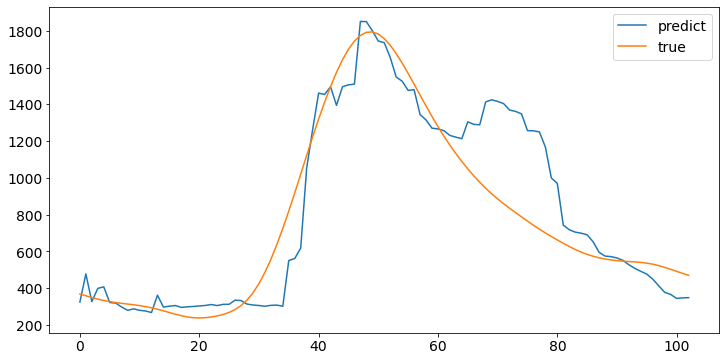

213.36184081836632


In [ ]:
y_pred = model.predict(test_set)  
df = pd.DataFrame(y_pred, columns = ['predict'])
df['true'] = test_set_y.reset_index(drop = True)
df.plot()
plt.legend()
plt.show()

print(np.sqrt(mean_squared_error(y_pred, test_set_y)))   

In [ ]:
cat_features_imp.head(50)

,f,v
83,1_수위(E지역)_diff,10628
10,1_수위(E지역),9767
77,7_유역평균강수_diff,7632
81,7_강우(D지역)_diff,7003
80,7_강우(C지역)_diff,6664
82,7_수위(D지역)_diff,6446
84,홍수기간,5584
43,6_강우(C지역),5501
17,2_수위(E지역),5232
0,홍수사상번호,5045


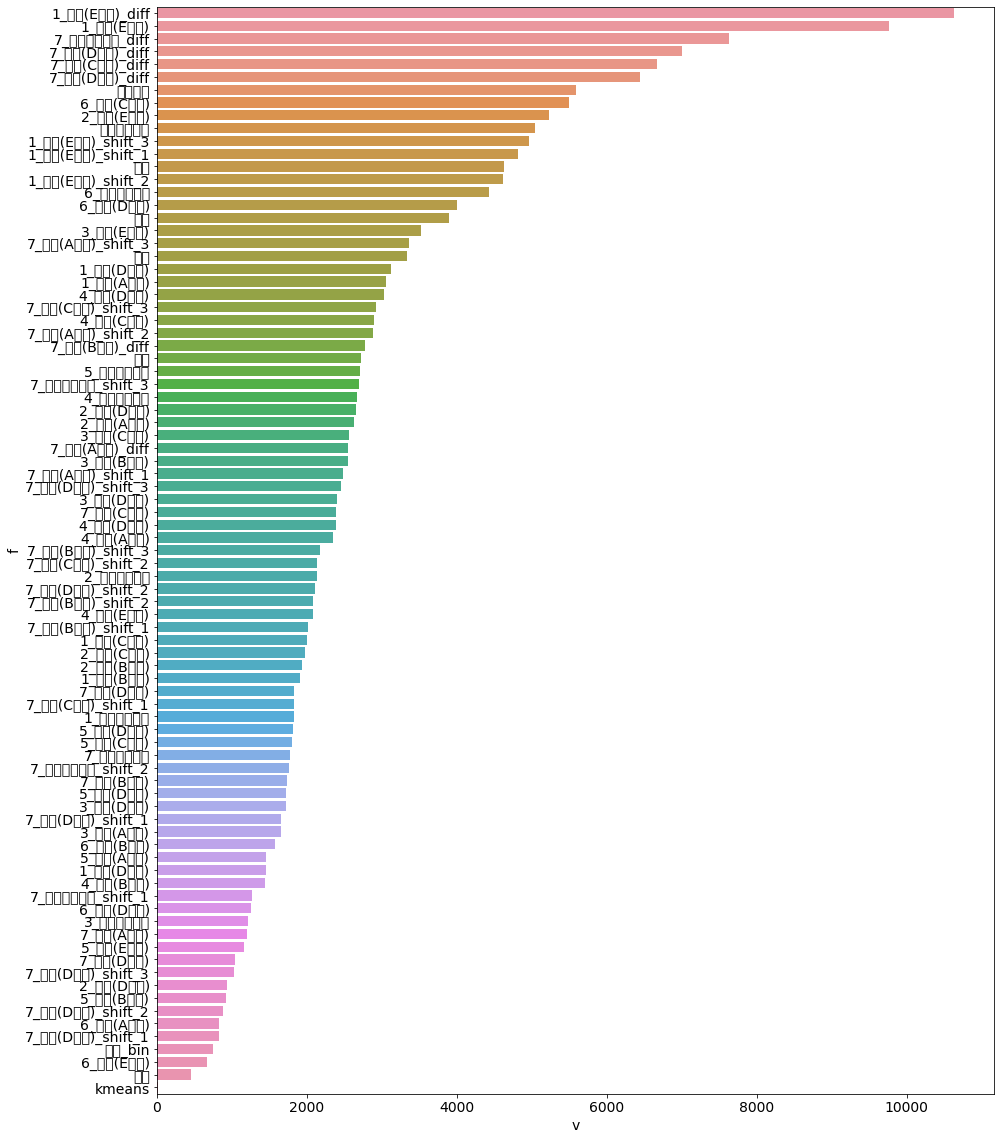

In [ ]:
plt.figure(figsize = (15, 20))
cat_features_imp = pd.DataFrame([model.feature_name_, model.feature_importances_]).T
cat_features_imp.columns = ['f', 'v']
cat_features_imp = cat_features_imp.sort_values(by = 'v', ascending = False)
sns.barplot(y = 'f', x = 'v', data = cat_features_imp)
plt.show()